# Lab 09 GNN - Understanding of the Dataset and the Graph Building  

# Goal 

In this lab section, you will need to do:
1. Load the dataset with pandas library.
2. Understand the data structure - `hits`, `particles` and `truth`
3. Apply selection on the dataset and filter out noise hits.
4. Make pairs for each node
5. Build a graph using true information
6. Build a graph using all information
7. Visualize graphs

# Introduction

In this Lab 09, we will use tracking data to be an exercise. This tracking data comes from a previous Kaggle challenge: [TrackML Particle Tracking Challenge](https://www.kaggle.com/c/trackml-particle-identification). Instead of using whole dataset, we only pick 10 events for this lab. 

At the [Large Hadron Collider](https://home.cern/science/accelerators/large-hadron-collider) at [CERN](https://home.cern), the particles which genetaed in a collision between proton bunches will leave a plenty of trajectories in detectors. The picture below is the [CMS](https://cms.cern/detector) detector.

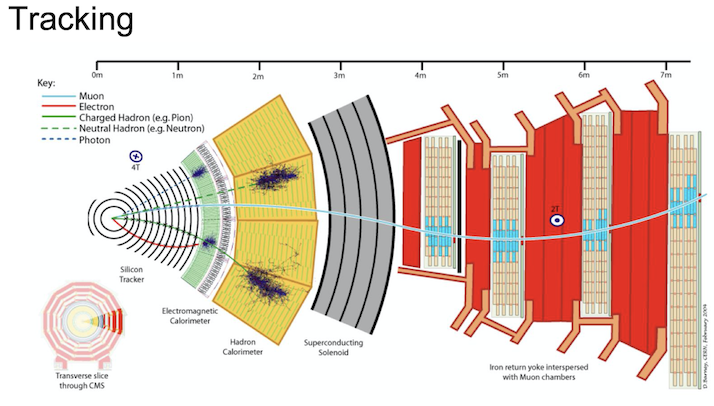

The reconstruction of particle tracks in a quick way is a challenge. Because the dataset is very large, it takes many computer power to reconstruct particle tracks. In the [TrackML Particle Tracking Challenge](https://www.kaggle.com/c/trackml-particle-identification), people want to build an algorithm for tracking problem. 

The tracking problem can be simplify to associate each hit to one track. Hits is the record of pixel when particles leaves signal in the silicon detectors. 


The Detector (pixel and/or strip) can be broken into different volumes. Each volume has layers. In this Lab 09, we only use the volume 8 to be the exercise. In the volume 8, there are 4 layers: layer 2, layer 4, layer 6 and layer 8. Further information of tracking can be found in the [TrackML Particle Tracking Challenge](https://www.kaggle.com/c/trackml-particle-identification).

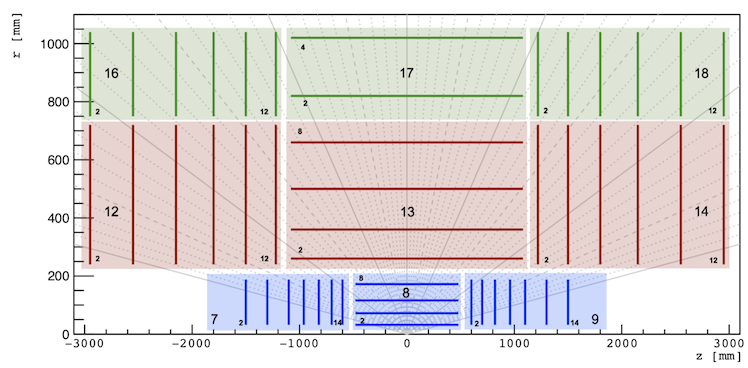

A type of Neural Network: Graph Neural Network is good at this tracking problem beacuse we can treat each point of hits to be "node". Links between each node can form "edge". A graph can be determined by a set of node and edge. Further information of graph can be found in references.

## In the following, we will be step by step to reveal the tracking data and build a graph.

# References:

[Graph Theory](https://en.wikipedia.org/wiki/Graph_theory)

[AIColliderSOS2021](https://github.com/vlimant/AIColliderSOS2021)

[hls4ml](https://github.com/vesal-rm/hls4ml/tree/master/example-prjs/graph/gnn_simple)
    
[exatrkx-neurips19](https://github.com/jmduarte/exatrkx-neurips19/blob/master/gnn-tracking/notebooks/DataAnalysis.ipynb)
    
    
[understanding graph neural networks](https://deepfindr.com/understanding-graph-neural-networks-part-1-3/)


 
    
Data Ref: [WalkThroughGNN4Tracking](https://github.com/exatrkx/exatrkx-iml2020/blob/main/notebooks/WalkThroughGNN4Tracking.ipynb)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
import tensorflow as tf
print(tf.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# !pip install https://github.com/LAL/trackml-library/archive/master.zip
    
# from trackml.dataset import load_dataset
# from trackml.dataset import load_event

2.4.1


# Part 1
In this part, you need to load the data from csv file locate in `/kaggle/input/phys591000-week09/train_10evts/train_10evts/`.  There are `hits`, `particles` and `truth` files for lots of events.

We only take event which is denoted `event000001000` in this exercise.

Also we only take hits in the volume 8.

* Please load dataset: `event000001000-hits.csv`, `event000001000-particles.csv` and `event000001000-truth.csv` in the `/kaggle/input/phys591000-week09/train_10evts/train_10evts/`
* Please selection hits in the volume 8.
* Please show data shapes of `event000001000-hits.csv`, `event000001000-particles.csv` and `event000001000-truth.csv` after the volume selection.
* Please show the top 5 rows of each dataset.

    * Hits:  
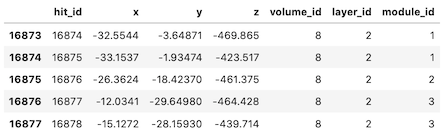
  
    * Particles:  
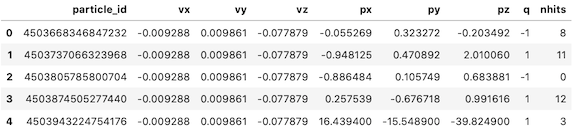
  
    * Truth:  
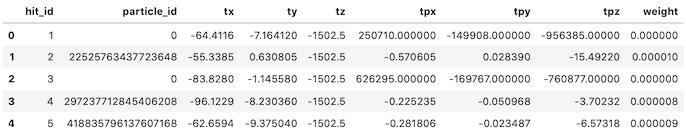

In [2]:
#################################################################################################################################
# Code for part 1
"""Load datasets."""
fn='/kaggle/input/phys591000-week09/train_10evts/train_10evts/event000001000-{}.csv'.format
H,P,T=(pd.read_csv(fn(t))for t in['hits','particles','truth'])
"""Selection hits in the volume 8."""
H8=H[H['volume_id']==8]
"""Show data shapes of datasets after the volume selection."""
print(H8.shape,P.shape,T.shape)
#################################################################################################################################

(29172, 7) (12263, 9) (120939, 9)


In [3]:
#################################################################################################################################
# Code for part 1 - the top 5 rows of hits.
H8.head()
#################################################################################################################################

,hit_id,x,y,z,volume_id,layer_id,module_id
16873,16874,-32.5544,-3.64871,-469.865,8,2,1
16874,16875,-33.1537,-1.93474,-423.517,8,2,1
16875,16876,-26.3624,-18.42370,-461.375,8,2,2
16876,16877,-12.0341,-29.64980,-464.428,8,2,3
16877,16878,-15.1272,-28.15930,-439.714,8,2,3


In [4]:
#################################################################################################################################
# Code for part 1 - the top 5 rows of particles.
P.head()
#################################################################################################################################

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824900,1,3


In [5]:
#################################################################################################################################
# Code for part 1 - the top 5 rows of truth.
T.head()
#################################################################################################################################

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.4116,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.3385,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.8280,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.1229,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.6594,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


# Part 2

You may notice that there are some columns with `particle_id=0` and `weight=0.000000` in the`truth`.
This kind of hits comes for noise.

In this part, we need to calculate transverse momentum `pt = px^2 + py^2` and create a `pt` column in `particles` table.

Then, to understand the true information of each hit, we will merge the `truth` into the `hits` based on `hit_id` column.

After we get a new `hits` table, we will remove noise from this new `hits` table. You will create`hits_no_noise` to store the data in this step.

Then, we will merge the `particle` into the `hits_no_noise` table based on `particle_id` column.

In the end of this part, we need to calculate `r = \sqrt(x^2 + y ^2)` and azimuthal angle `phi` and then create a `r` column and a `phi` column in the `hits_no_noise` table.

* Please calculate transverse momentum `pt` and create a `pt` column in `particles` table  and show data shape and top of 5 rows.


* Please merge the `truth` into the `hits` based on `hit_id` column and define it to be `new_hits` and show data shape and top of 5 rows. 


* Please remove noise from the `new_hits` table and then create`hits_no_noise` to store the data without noise.
  Please show data shape and top of 5 rows. 



* Please merge the `particles` into the `hits_no_noise` table based on `particle_id` column and show data shape and top of 5 rows.

* Please calculate `r = \sqrt(x^2 + y ^2)` and azimuthal angle `phi` and then create a `r` column and a `phi` column in the `hits_no_noise` table.
  Please show data shape and top of 5 rows. 


Hint: [transverse momentum](https://en.wikipedia.org/wiki/Transverse_mass)   
Hint: [pandas.DataFrame.merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)   



In [6]:
#################################################################################################################################
# Code for part 2
# Please calculate transverse momentum `pt` and create a `pt` column in `particles` table and show data shape and top of 5 rows. 
#################################################################################################################################
P['pt']=P['px']**2+P['py']**2
def dst5r(D):
    print(D.shape)
    return D.head()
dst5r(P)
#################################################################################################################################

(12263, 10)


,particle_id,vx,vy,vz,px,py,pz,q,nhits,pt
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8,0.107559
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11,1.120680
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0,0.797037
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12,0.524274
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824900,1,3,512.022164


In [7]:
#################################################################################################################################
# Code for part 2
# Please merge the `truth` into the `hits` based on `hit_id` column and define it to be `new_hits` and show data shape and top of 5 rows. 
#################################################################################################################################
nH=H8.merge(T,on='hit_id')
dst5r(nH)
#################################################################################################################################

(29172, 15)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,16874,-32.5544,-3.64871,-469.865,8,2,1,824163129872097282,-32.5551,-3.64680,-469.869,-0.177629,-0.141668,-0.372036,0.000014
1,16875,-33.1537,-1.93474,-423.517,8,2,1,0,-33.1524,-1.93819,-423.513,-541134.000000,-118776.000000,-832506.000000,0.000000
2,16876,-26.3624,-18.42370,-461.375,8,2,2,0,-26.3595,-18.42700,-461.376,476090.000000,345468.000000,-808697.000000,0.000000
3,16877,-12.0341,-29.64980,-464.428,8,2,3,220687857910562818,-12.0326,-29.65060,-464.427,0.028111,-0.169886,-0.029767,0.000016
4,16878,-15.1272,-28.15930,-439.714,8,2,3,824170895156183040,-15.1264,-28.15970,-439.722,-0.149088,-0.154855,-1.379990,0.000012


In [8]:
#################################################################################################################################
# Code for part 2
# Please remove noise from the `new_hits` table and then create`hits_no_noise` to store the data without noise.
# Please show data shape and top of 5 rows. 
#################################################################################################################################
Hnn=nH[nH['particle_id']!=0]
dst5r(Hnn)
#################################################################################################################################

(26955, 15)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,16874,-32.554400,-3.64871,-469.865,8,2,1,824163129872097282,-32.555100,-3.6468,-469.869,-0.177629,-0.141668,-0.372036,0.000014
3,16877,-12.034100,-29.64980,-464.428,8,2,3,220687857910562818,-12.032600,-29.6506,-464.427,0.028111,-0.169886,-0.029767,0.000016
4,16878,-15.127200,-28.15930,-439.714,8,2,3,824170895156183040,-15.126400,-28.1597,-439.722,-0.149088,-0.154855,-1.379990,0.000012
7,16881,0.269687,-32.00040,-424.144,8,2,4,112599405269360642,0.267325,-32.0003,-424.146,-0.131193,-0.238106,-0.114352,0.000011
8,16882,-0.905279,-34.14660,-425.176,8,2,5,112599405269360642,-0.908831,-34.1479,-425.176,-0.129329,-0.238821,-0.114881,0.000009


In [9]:
#################################################################################################################################
# Code for part 2
# Please merge the `particle` into the `hits_no_noise` table based on `particle_id` column and show data shape and top of 5 rows. 
#################################################################################################################################
HPT=Hnn.merge(P,on='particle_id')
dst5r(HPT)
#################################################################################################################################

(26955, 24)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,weight,vx,vy,vz,px,py,pz,q,nhits,pt
0,16874,-32.55440,-3.64871,-469.865,8,2,1,824163129872097282,-32.55510,-3.6468,...,0.000014,-9.09144,16.6837,-418.897,-0.165180,-0.155435,-0.372320,1,11,0.051444
1,16877,-12.03410,-29.64980,-464.428,8,2,3,220687857910562818,-12.03260,-29.6506,...,0.000016,-25.31500,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733
2,25809,-8.03781,-71.94210,-471.179,8,4,8,220687857910562818,-8.03757,-71.9421,...,0.000013,-25.31500,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733
3,33311,-10.27360,-116.29700,-478.431,8,6,13,220687857910562818,-10.27660,-116.2980,...,0.000010,-25.31500,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733
4,39999,-23.11160,-170.11500,-487.432,8,8,18,220687857910562818,-23.11410,-170.1150,...,0.000008,-25.31500,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733


In [10]:
#################################################################################################################################
# Code for part 2
# Please calculate `r = \sqrt(x^2 + y ^2)` and azimuthal angle `phi` and then create a `r` column and a `phi` column in the `hits_no_noise` table.
# Please show data shape and top of 5 rows. 
#################################################################################################################################
HPT['r']=np.sqrt(HPT['x']**2+HPT['y']**2)
HPT['phi']=np.angle(HPT['x']+1j*HPT['y'])
hits_no_noise=HPT
dst5r(HPT)
#################################################################################################################################

(26955, 26)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,pt,r,phi
0,16874,-32.55440,-3.64871,-469.865,8,2,1,824163129872097282,-32.55510,-3.6468,...,16.6837,-418.897,-0.165180,-0.155435,-0.372320,1,11,0.051444,32.758236,-3.029978
1,16877,-12.03410,-29.64980,-464.428,8,2,3,220687857910562818,-12.03260,-29.6506,...,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733,31.998909,-1.956357
2,25809,-8.03781,-71.94210,-471.179,8,4,8,220687857910562818,-8.03757,-71.9421,...,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733,72.389724,-1.682061
3,33311,-10.27360,-116.29700,-478.431,8,6,13,220687857910562818,-10.27660,-116.2980,...,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733,116.749900,-1.658907
4,39999,-23.11160,-170.11500,-487.432,8,8,18,220687857910562818,-23.11410,-170.1150,...,21.0297,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733,171.677777,-1.705828


# Seletect hits at barrel layers

After we remove the noise, we will group hits at barrel layers.  
Please just run the code below and to see what happended.


In [11]:
# define barrel layers 
# (8,2) -> 8 means volume 8, 2 means layer 2
vlids = [(8,2), (8,4), (8,6), (8,8)]

n_det_layers = len(vlids)

# Select barrel layers and assign convenient layer number [0-9]
vlid_groups = hits_no_noise.groupby(['volume_id', 'layer_id'])
hits_barrel = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i) for i in range(n_det_layers)])

print("hits_barrel.shape: ", hits_barrel.shape)
hits_barrel.head()

hits_barrel.shape:  (26955, 27)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,pt,r,phi,layer
0,16874,-32.554400,-3.64871,-469.865,8,2,1,824163129872097282,-32.555100,-3.6468,...,-418.897,-0.165180,-0.155435,-0.372320,1,11,0.051444,32.758236,-3.029978,0
1,16877,-12.034100,-29.64980,-464.428,8,2,3,220687857910562818,-12.032600,-29.6506,...,-455.162,0.058708,-0.162130,-0.030876,1,9,0.029733,31.998909,-1.956357,0
5,16878,-15.127200,-28.15930,-439.714,8,2,3,824170895156183040,-15.126400,-28.1597,...,-283.343,-0.137170,-0.164479,-1.380350,1,12,0.045869,31.965268,-2.063760,0
6,16881,0.269687,-32.00040,-424.144,8,2,4,112599405269360642,0.267325,-32.0003,...,-416.695,-0.140320,-0.232814,-0.114528,-1,14,0.073892,32.001536,-1.562369,0
7,16882,-0.905279,-34.14660,-425.176,8,2,5,112599405269360642,-0.908831,-34.1479,...,-416.695,-0.140320,-0.232814,-0.114528,-1,14,0.073892,34.158598,-1.597302,0


# Remove duplicated Hits
In some case, some particles can leave serval hits in a layer.  

Therefore, we will remove duplicated hits based on minium `r`.   

Please just run the code below and to see what happended.


In [12]:
%%time
hits_barrel_no_duplicate_hits = hits_barrel.loc[hits_barrel.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()["r"]]
hits_barrel_no_duplicate_hits = hits_barrel_no_duplicate_hits.assign(evtid=1000)
print("hits_barrel_no_duplicate_hits.shape: ", hits_barrel_no_duplicate_hits.shape)
hits_barrel_no_duplicate_hits.head()

hits_barrel_no_duplicate_hits.shape:  (21716, 28)
CPU times: user 17.4 s, sys: 176 ms, total: 17.6 s
Wall time: 17.5 s


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,r,phi,layer,evtid
11539,20880,-6.36936,31.6032,-20.0858,8,2,109,4503668346847232,-6.37305,31.6019,...,-0.055269,0.323272,-0.203492,-1,8,0.107559,32.238657,1.769674,0,1000
11540,29323,-16.95790,71.0024,-45.6394,8,4,218,4503668346847232,-16.96210,71.0005,...,-0.055269,0.323272,-0.203492,-1,8,0.107559,72.999392,1.805240,1,1000
11541,35621,-31.18910,112.0460,-73.2057,8,6,302,4503668346847232,-31.18840,112.0460,...,-0.055269,0.323272,-0.203492,-1,8,0.107559,116.305916,1.842283,2,1000
11542,42238,-54.56060,162.8250,-108.4770,8,8,453,4503668346847232,-54.55930,162.8260,...,-0.055269,0.323272,-0.203492,-1,8,0.107559,171.723148,1.894125,3,1000
20407,23346,-28.03810,14.2383,59.5952,8,2,127,4503737066323968,-28.03780,14.2389,...,-0.948125,0.470892,2.010060,1,11,1.120680,31.446212,2.671709,0,1000


# Part 3

If we take all particle to do analyze, we will run out of memory.
Therefore, we will only pick last 10 particles for further analysis.

* Please pick `particle_id` for last 10 particles and make a numpy list
* According to previous `particle_id` list, please select those data from `hits_barrel_no_duplicate_hits`.    

  Please create `ten_particle_results` to store this information and show data shape and top of 5 rows.

 Hint: [numpy sort](https://numpy.org/doc/stable/reference/generated/numpy.sort.html)   
 Hint: [numpy unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html)


In [13]:
#################################################################################################################################
# Code for part 3
#  Please pick `particle_id` for last 10 particles and make a numpy list
#  According to previous `particle_id` list, please select those data from `hits_barrel_no_duplicate_hits`.  
#  Please create `ten_particle_results` to store this information and show data shape and top of 5 rows.
#################################################################################################################################
Hbn=hits_barrel_no_duplicate_hits
nplist=Hbn['particle_id'].unique()[-10:]
tenp=Hbn[np.in1d(Hbn['particle_id'],nplist)]
ten_particle_results=tenp
dst5r(tenp)
#################################################################################################################################

(32, 28)


,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,r,phi,layer,evtid
5605,21357,-32.0411,-0.989847,-16.04540,8,2,112,968297628104130560,-32.0413,-0.993324,...,-0.191965,0.003783,-0.065734,-1,13,0.036865,32.056386,-3.110709,0,1000
5606,28417,-71.9777,-6.770300,-29.56960,8,4,193,968297628104130560,-71.9778,-6.770040,...,-0.191965,0.003783,-0.065734,-1,13,0.036865,72.295410,-3.047808,1,1000
5607,35780,-114.9480,-19.145300,-44.43730,8,6,314,968297628104130560,-114.9450,-19.154500,...,-0.191965,0.003783,-0.065734,-1,13,0.036865,116.531477,-2.976551,2,1000
5608,42386,-166.0260,-42.174700,-62.11550,8,8,471,968297628104130560,-166.0260,-42.174200,...,-0.191965,0.003783,-0.065734,-1,13,0.036865,171.298973,-2.892830,3,1000
12590,21162,-26.2434,19.103000,-4.48438,8,2,111,968298246579421184,-26.2379,19.114600,...,-0.419300,0.150182,-0.032330,1,12,0.198367,32.459831,2.512376,0,1000


# Part 4

It's time to visualize our ten partilce tracks.

* Please make a 3D figure to show these 10 particle tracks in cardetial coordinate (x-y-z).
  You need to combine a scatter plot and a line plot in this figure. Scatter plot can help us know hit's position.
* Please make a 2D figure to show these 10 particle tracks in cylinder coordinate (z-r).
  You need to combine a scatter plot and a line plot in this figure. Scatter plot can help us know hit's position.


Hint: [Python 3D Plot](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)

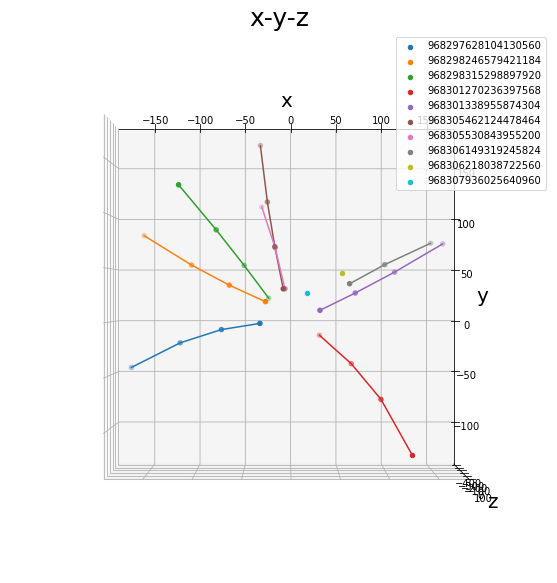

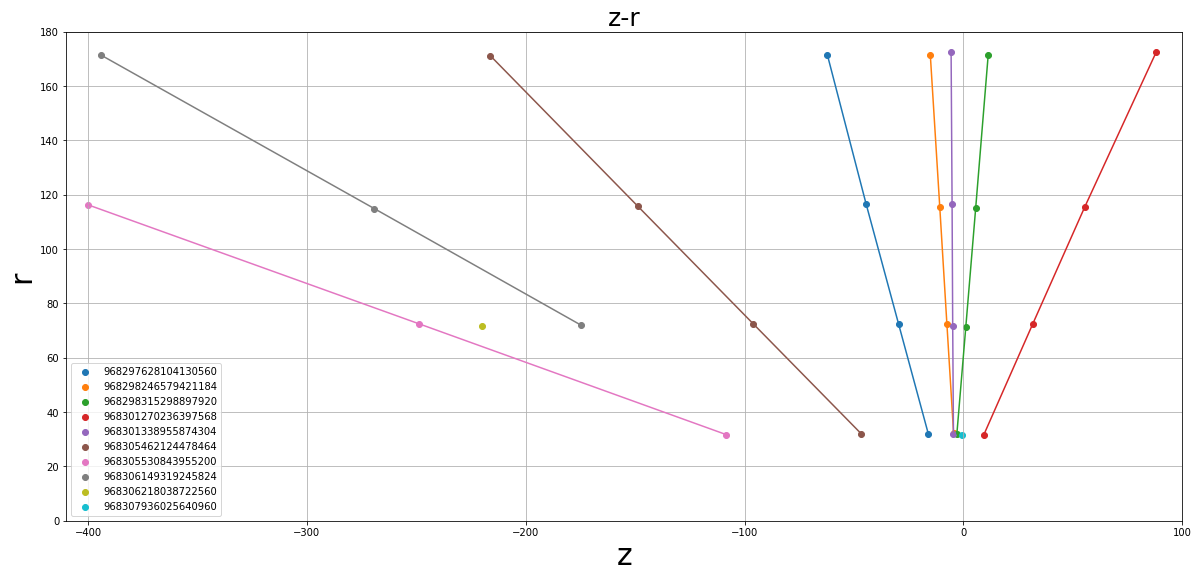

In [14]:
#################################################################################################################################
# Code for part 4
# Please make a 3D figure to show this 10 particle tracks in cardetial coordinate (x-y-z).
#  You need to combine a scatter plot and a line plot in this figure. Scatter plot can help us know hit's position.
# Please make a 2D figure to show this 10 particle tracks in cylinder coordinate (z-r).
#  You need to combine a scatter plot and a line plot in this figure. Scatter plot can help us know hit's position.


#################################################################################################################################
# 3D figure to show these 10 particle tracks in cardetial coordinate. (x-y-z)
from mpl_toolkits import mplot3d
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for p in nplist:
    X,Y,Z=(tenp[w][tenp['particle_id']==p]for w in'xyz')
    ax.plot3D(   X,Y,Z)
    ax.scatter3D(X,Y,Z,label=p)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.set_zlabel('z',fontsize=20)
ax.view_init(90,-90)
plt.title('x-y-z',fontsize=25)
plt.legend()
# 2D figure to show these 10 particle tracks in cylinder coordinate. (z-r) 
plt.figure(figsize=(20,9))
for p in nplist:
    Z,R=(tenp[w][tenp['particle_id']==p]for w in'zr')
    plt.plot(   Z,R)
    plt.scatter(Z,R,label=p)
plt.xlim((-410,100))
plt.ylim((0,180))
plt.xlabel('z',fontsize=30)
plt.ylabel('r',fontsize=30)
plt.title('z-r',fontsize=25)
plt.legend()
plt.grid()
plt.show()
#################################################################################################################################

# Make Pairs

Now, we will follow [exatrkx-neurips19](https://github.com/jmduarte/exatrkx-neurips19/blob/master/gnn-tracking/notebooks/DataAnalysis.ipynb) to make pairs for each node.

Please just run the code below and you will get `pairs`. 

In `pairs`, it records every connection of each hit. 
The connection from the same particle will be denoted to `True`. Otherwise, it will be marked to be `False` 

In [15]:
def cal_deta(hitpair):
    r1 = hitpair.r_1
    r2 = hitpair.r_2
    z1 = hitpair.z_1
    z2 = hitpair.z_2
    
    R1 = np.sqrt(r1**2 + z1**2)
    R2 = np.sqrt(r2**2 + z2**2)
    theta1 = np.arccos(z1/R1)
    theta2 = np.arccos(z2/R2)
#     theta1 = np.arctan(r1/z1)
#     theta2 = np.arctan(r2/z2)
    eta1 = -np.log(np.tan(theta1/2.0))
    eta2 = -np.log(np.tan(theta2/2.0))
    return eta1 - eta2

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi


def create_segments(hits, gid_start, gid_end, gid_keys='layer'):
    segments = []
    hit_gid_groups = hits.groupby(gid_keys)

    # Loop over geometry ID pairs
    for gid1, gid2 in zip(gid_start, gid_end):
        hits1 = hit_gid_groups.get_group(gid1)
        hits2 = hit_gid_groups.get_group(gid2)

        # Join all hit pairs together
        hit_pairs = pd.merge(
            hits1.reset_index(), hits2.reset_index(),
            how='inner', on='evtid', suffixes=('_1', '_2'))
        
#         print(hit_pairs.columns)
        
        
        # Calculate coordinate differences
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
        deta = cal_deta(hit_pairs)

        # Identify the true pairs
        y = (hit_pairs.particle_id_1 == hit_pairs.particle_id_2) & (hit_pairs.particle_id_1 != 0)

        # Put the results in a new dataframe
        df_pairs = hit_pairs[['evtid', 'index_1', 'index_2', 'hit_id_1', 'hit_id_2', 'layer_1', 'layer_2',"particle_id_1",'particle_id_2', 'z_1', 'z_2',"r_1","r_2"]].assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slope, z0=z0, deta=deta)
        print('processed:', gid1, gid2, "True edges {} and Fake Edges {}".format(df_pairs[df_pairs['y']==True].shape[0], df_pairs[df_pairs['y']==False].shape[0]))
        segments.append(df_pairs)
    return segments

In [16]:
%%time
gid_keys = 'layer'
n_det_layers = 4
gid_start = np.arange(0, n_det_layers-1)
gid_end = np.arange(1, n_det_layers)

print("gid_start: ", gid_start)
print("gid_end: ", gid_end)

segments = create_segments(ten_particle_results, gid_start, gid_end, gid_keys=gid_keys)

pairs = pd.concat(segments, ignore_index=True)
print("pairs.shape: ", pairs.shape)
pairs.head()

gid_start:  [0 1 2]
gid_end:  [1 2 3]
processed: 0 1 True edges 7 and Fake Edges 65
processed: 1 2 True edges 8 and Fake Edges 64
processed: 2 3 True edges 7 and Fake Edges 49
pairs.shape:  (200, 20)
CPU times: user 98.3 ms, sys: 8.59 ms, total: 107 ms
Wall time: 95.1 ms


,evtid,index_1,index_2,hit_id_1,hit_id_2,layer_1,layer_2,particle_id_1,particle_id_2,z_1,z_2,r_1,r_2,dphi,dz,dr,y,phi_slope,z0,deta
0,1000,5605,5606,21357,28417,0,1,968297628104130560,968297628104130560,-16.0454,-29.56960,32.056386,72.295410,0.062902,-13.52420,40.239024,True,0.001563,-5.271357,-0.083303
1,1000,5605,12591,21357,29470,0,1,968297628104130560,968298246579421184,-16.0454,-7.52188,32.056386,72.297940,-0.526385,8.52352,40.241554,False,-0.013081,-22.835228,-0.377839
2,1000,5605,12305,21357,30516,0,1,968297628104130560,968298315298897920,-16.0454,1.10938,32.056386,71.304710,-0.859345,17.15478,39.248324,False,-0.021895,-30.056705,-0.497250
3,1000,5605,16336,21357,30055,0,1,968297628104130560,968301270236397568,-16.0454,31.71550,32.056386,72.459176,2.562157,47.76090,40.402790,False,0.063415,-53.939858,-0.906501
4,1000,5605,9540,21357,29044,0,1,968297628104130560,968301338955874304,-16.0454,-4.87812,32.056386,71.620929,-2.784588,11.16728,39.564543,False,-0.070381,-25.093467,-0.413634


# Part 5

* Please select `y = True` to pick up true edge in the `pairs` and stroe in `true_edges` and show data shape and top of 5 rows.
* Please a figure to show a network. In this network, every node is fully connected to each node.  
  Please let truth edges in this figure to be grey and fake edges to be red.
  
  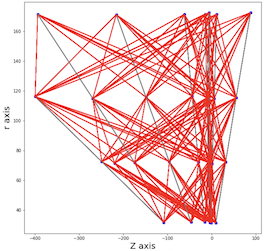

In [17]:
#################################################################################################################################
# Code for part 5
# Please select `y = True` to pick up true edge in the `pairs` and store in `true_edges` and show data shape and top of 5 rows.
#################################################################################################################################
true_edges=pairs[pairs['y']]
dst5r(true_edges)
#################################################################################################################################

(22, 20)


,evtid,index_1,index_2,hit_id_1,hit_id_2,layer_1,layer_2,particle_id_1,particle_id_2,z_1,z_2,r_1,r_2,dphi,dz,dr,y,phi_slope,z0,deta
0,1000,5605,5606,21357,28417,0,1,968297628104130560,968297628104130560,-16.04540,-29.56960,32.056386,72.295410,0.062902,-13.52420,40.239024,True,0.001563,-5.271357,-0.083303
10,1000,12590,12591,21162,29470,0,1,968298246579421184,968298246579421184,-4.48438,-7.52188,32.459831,72.297940,0.133716,-3.03750,39.838109,True,0.003356,-2.009445,-0.033863
20,1000,12303,12305,21082,30516,0,1,968298315298897920,968298315298897920,-2.97367,1.10938,32.013122,71.304710,-0.056832,4.08305,39.291589,True,-0.001446,-6.300366,-0.108314
30,1000,16334,16336,22193,30055,0,1,968301270236397568,968301270236397568,9.26510,31.71550,31.511397,72.459176,-0.167158,22.45040,40.947779,True,-0.004082,-8.011624,-0.134865
40,1000,9538,9540,20356,29044,0,1,968301338955874304,968301338955874304,-4.54063,-4.87812,31.940964,71.620929,0.031411,-0.33749,39.679965,True,0.000792,-4.268963,-0.073625


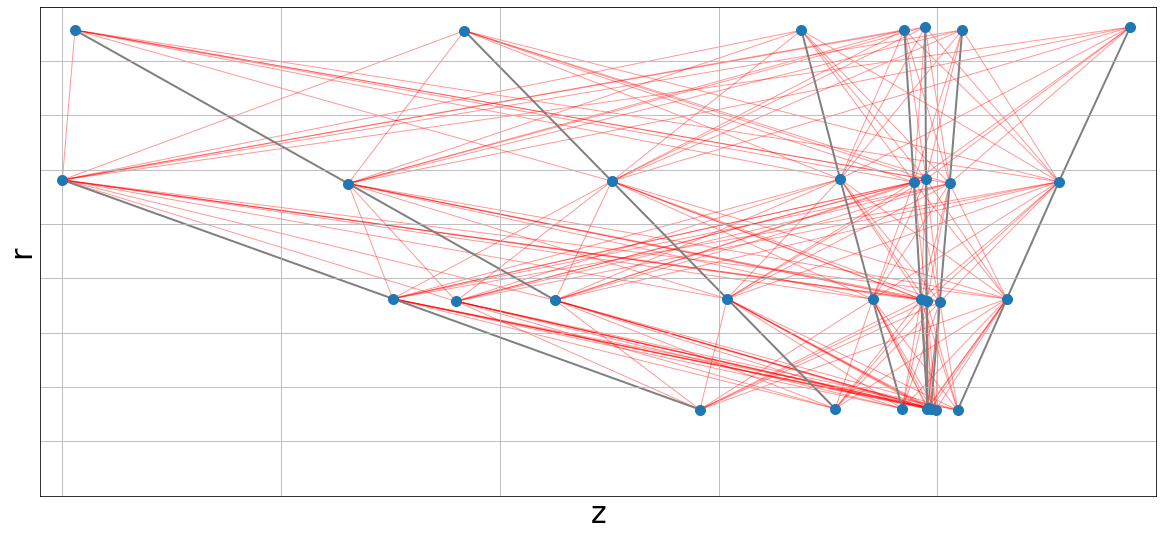

In [18]:
#################################################################################################################################
# Code for part 5
# Please a figure to show a network. In this network, every node is fully connected to each node.  
# Please let truth edges in this figure to be grey and fake edges to be red.
#################################################################################################################################
G=nx.Graph()
pos={i:np.array([z,r])for i,z,r in tenp[['hit_id','z','r']].values}
G.add_nodes_from(tenp['hit_id'])
G.add_edges_from(pairs[['hit_id_1','hit_id_2']].values)
plt.figure(figsize=(20,9))
nx.draw_networkx_nodes(G,pos,node_size=100)
nx.draw_networkx_edges(G,pos,edgelist=pairs[pairs['y']==False][['hit_id_1','hit_id_2']].values,edge_color='red',alpha=.4)
nx.draw_networkx_edges(G,pos,edgelist=true_edges[['hit_id_1','hit_id_2']].values,edge_color='gray',width=2)
plt.xlim((-410,100))
plt.ylim((0,180))
plt.xlabel('z',fontsize=30)
plt.ylabel('r',fontsize=30)
plt.grid()
plt.show()
#################################################################################################################################

# Part 6

We will construct two graphs using `pairs` and `true_edges`.

* Please construct a graph `Graph_Truth`.    
  You should use `hit_id` in `ten_particle_results`  to construct nodes.  
  You should use `hit_id_1` and `hit_id_2` in `true_edges` to construct true edges.    
  
* Please construct a graph `Graph_Total`.    
  You should use `hit_id` in `ten_particle_results` to construct nodes.     
  You should use `hit_id_1` and `hit_id_2` in `pairs` to construct every edges.    
  

* Please visualize two graphs. (`Graph_Truth` in red and `Graph_Total` in blue)



Hint: [NetworkX Visualization](https://networkx.org/documentation/stable/tutorial.html)    
Hint: [NetworkX: draw_circular](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.drawing.nx_pylab.draw_circular.html)

In [19]:
%%time
#################################################################################################################################
# Code for part 6
# Please construct a graph `Graph_Truth`. 
#  You should use `hit_id` in `ten_particle_results` to construct nodes.
#  You should use `hit_id_1` and `hit_id_2` in `true_edges` to construct true edges.
#################################################################################################################################
Graph_Truth=nx.Graph()
Graph_Truth.add_nodes_from(ten_particle_results['hit_id'])
Graph_Truth.add_edges_from(true_edges[['hit_id_1','hit_id_2']].values)
#################################################################################################################################

CPU times: user 1.41 ms, sys: 36 µs, total: 1.44 ms
Wall time: 1.37 ms


In [20]:
#################################################################################################################################
# Code for part 6
# Please construct a graph `Graph_Total`. 
#  You should use `hit_id` in `ten_particle_results` to construct nodes.
#  You should use `hit_id_1` and `hit_id_2` in `pairs` to construct every edges.
#################################################################################################################################
Graph_Total=nx.Graph()
Graph_Total.add_nodes_from(ten_particle_results['hit_id'])
Graph_Total.add_edges_from(pairs[['hit_id_1','hit_id_2']].values)
#################################################################################################################################

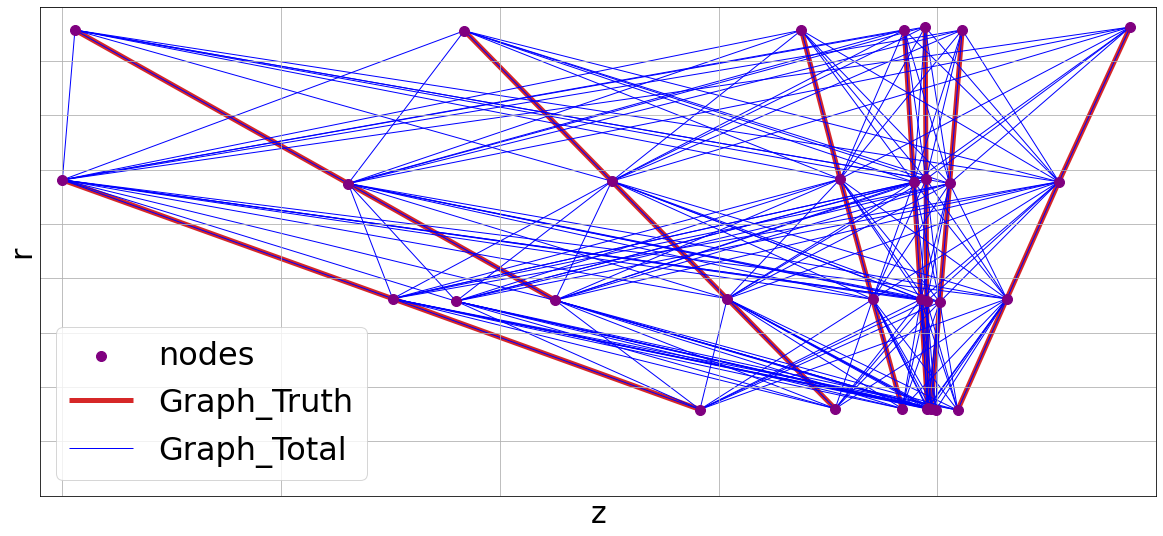

In [21]:
#################################################################################################################################
# Code for part 6
# Please visualize two graphs. (`Graph_True` in red and `Graph_Total` in blue)
#################################################################################################################################
Pos={i:np.array([z,r])for i,z,r in ten_particle_results[['hit_id','z','r']].values}
plt.figure(figsize=(20,9))
nx.draw_networkx_nodes(Graph_Truth,Pos,label='nodes',node_color='purple',node_size=100)
nx.draw_networkx_edges(Graph_Truth,Pos,label='Graph_Truth',edge_color='tab:red',width=5)
nx.draw_networkx_edges(Graph_Total,Pos,label='Graph_Total',edge_color='blue')
plt.xlim((-410,100))
plt.ylim((0,180))
plt.xlabel('z',fontsize=30)
plt.ylabel('r',fontsize=30)
plt.legend(fontsize=32)
plt.grid()
plt.show()
#################################################################################################################################